<a href="https://colab.research.google.com/github/ehsung/PUBH6886/blob/main/PUBH6886_Homework_4_EHS_COMPLETED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PUBH 6886 Homework 4
## Completed by Edward Sung
## Completed on 12/10/24

Note: suppressWarnings() is used on train() since it generates a lot of warnings related to:

Warning message:
“Setting row names on a tibble is deprecated.”

In [ ]:
# Install Libraries
install.packages("caret")
install.packages("ggplot2")
install.packages("pROC")
install.packages("leaps")
install.packages("glmnet")
install.packages("pls")
install.packages("gridExtra")
install.packages("rpart")
install.packages("rpart.plot")
install.packages("randomForest")
install.packages("gbm")

In [ ]:
# Load libraries
library(dplyr)
library(caret)
library(ggplot2)
library(pROC)
library(readr)
library(leaps)
library(glmnet)
library(pls)
library(gridExtra)
library(splines)
library(rpart)
library(rpart.plot)
library(randomForest)
library(gbm)

# Table of Contents

>[Question 1](#scrollTo=tiPbKT37MtsS)

>>[(a)](#scrollTo=iFLpRuVwNMzR)

>>[(b)](#scrollTo=ZIpUG1pLSAKk)

>>[(c)](#scrollTo=VL1nwpcYTwEP)

>[Question 2](#scrollTo=2dkuY3YBffOi)

>>[(a)](#scrollTo=U9SgGOwDoKM0)

>>[(b)](#scrollTo=gVU5Hj2LseOL)

>>[(c)](#scrollTo=x4nIrHno0BmI)

>>[(d)](#scrollTo=cHmDeCPT-nLo)

>>[(e)](#scrollTo=t-BwZNphfSvN)



# Question 1

(35 pts.) Data in the file `bmd_females.csv` was collected on a sample of 259 adolescent females. Measures collected include `rspnbmd`: relative spinal bone mineral density measurements corresponding to the difference in spinal bone mineral density measurements taken at two consecutive visits divided by the average and `age`: (in years) corresponding to the average age over the two visits. For each part below, if you use the `train()` function to perform cross-validation, set the seed to 1234 (`set.seed(1234)`) prior to running the function.

In [ ]:
# Load the bmd_females.csv data
bmd_females_data <- read_csv("/content/bmd_females.csv")

## (a)

(5 pts.) Make a scatter plot showing the relationship between `rspnbmd` and `age`. Clearly label the axes. Does there appear to be a linear relationship between `rspnbmd` and `age`?

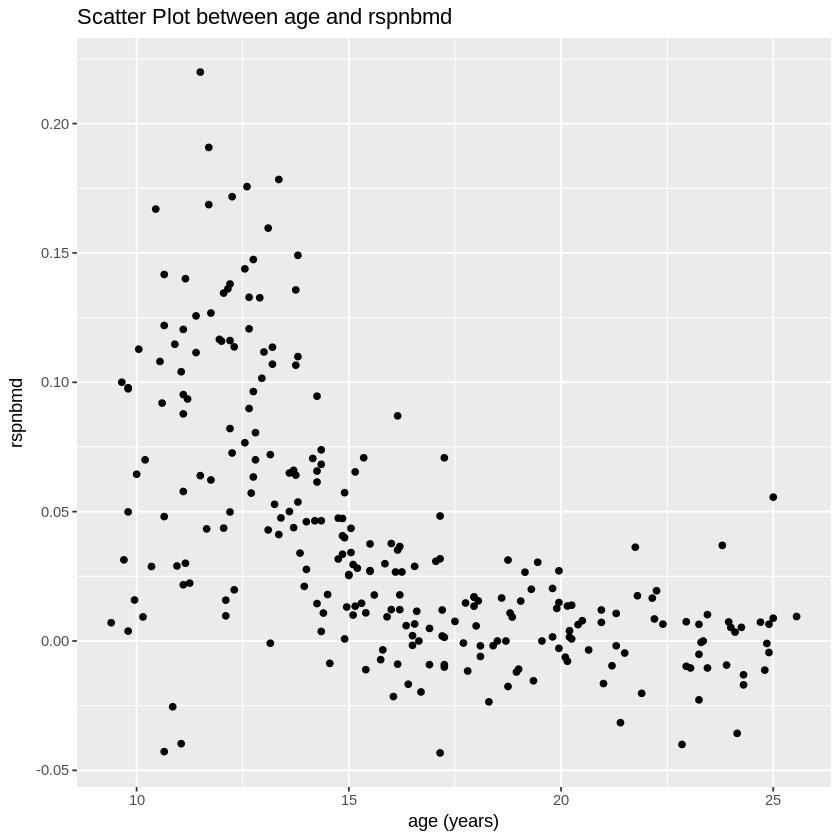

In [22]:
# Plots age vs rspnbmd
ggplot(bmd_females_data, aes(x = age, y = rspnbmd)) +
  geom_point() +
  labs(x = "age (years)",
       y = "rspnbmd",
       title = "Scatter Plot between age and rspnbmd")

It looks more like an exponential decay curve than a linear relationship.

## (b)

(10 pts.) Regardless of your response in part (a), fit a linear regression model with `rspnbmd` as the response and with `age` as the only predictor. Use 10-fold CV to compute the CV RMSE and CV R2.

In [5]:
# Set seed
set.seed(1234)

# Define training control for 10-fold CV
train_control <- trainControl(method = "cv", number = 10)

# Fit linear regression model
bmd_females_lm_10cv <- suppressWarnings(train(rspnbmd ~ age,
                                              data = bmd_females_data,
                                              method = "lm",
                                              trControl = train_control))

# Get CV RMSE and R2
bmd_females_lm_10cv_rmse <- bmd_females_lm_10cv$results$RMSE
bmd_females_lm_10cv_r2 <- bmd_females_lm_10cv$results$Rsquared

# Print the results
print(paste("Linear 10 CV RMSE:", bmd_females_lm_10cv_rmse))
print(paste("Linear 10 CV R2:", bmd_females_lm_10cv_r2))

[1] "Linear 10 CV RMSE: 0.0403310524469309"
[1] "Linear 10 CV R2: 0.403509740385206"


## (c)

(20 pts.) Fit a cubic spline model with `rspnbmd` as the response and `age` as the only predictor. To arrive at your final model, use 10-fold CV RMSE to select the number of internal knots (consider values from 1 to 7). Provide a table or graph that shows how you selected the number of internal knots. Provide a graphical description of the final model that you select and report the CV RMSE and CV R2. Does your selected cubic spline model predict `rspnbmd` more accurately than the linear model that you fit in part (b)?

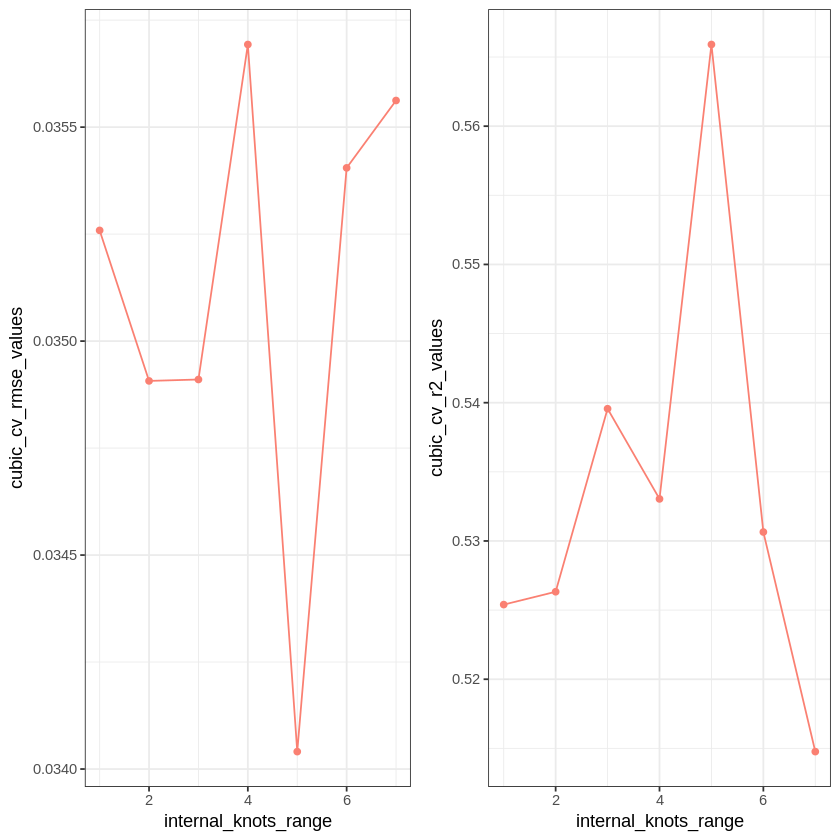

In [6]:
# Set seed
set.seed(1234)

# Define training control for 10-fold CV
train_control <- trainControl(method = "cv", number = 10)

# Define a range of internal knots to consider 1 to 7
internal_knots_range <- 1:7

# Store CV RMSE and R2 for each number of knots
cubic_cv_rmse_values <- numeric(length(internal_knots_range))
cubic_cv_r2_values <- numeric(length(internal_knots_range))

# Loop through different knot values and fit cubic spline model
for (i in internal_knots_range) {
  cubic_model <- suppressWarnings(lm(rspnbmd ~ bs(age, df = i + 3, degree = 3),
                                        data = bmd_females_data))

  cubic_model_train <- suppressWarnings(train(x = model.matrix(cubic_model)[,-1],
                                              y = bmd_females_data$rspnbmd,
                                              method = "lm",
                                              trControl = train_control))

  # Store CV RMSE and R2
  cubic_cv_rmse_values[i] <- cubic_model_train$results$RMSE
  cubic_cv_r2_values[i] <- cubic_model_train$results$Rsquared
}

# Graphical Plot of 10 CV RMSE for each number of knots
p1 <- data.frame(internal_knots_range, cubic_cv_rmse_values) %>%
  ggplot(aes(x = internal_knots_range, y = cubic_cv_rmse_values)) +
  geom_point(col = "salmon") + geom_line(col = "salmon") +
  theme_bw()

# Graphical Plot of 10 CV R2 for each number of knots
p2 <- data.frame(internal_knots_range, cubic_cv_r2_values) %>%
  ggplot(aes(x = internal_knots_range, y = cubic_cv_r2_values)) +
  geom_point(col = "salmon") + geom_line(col = "salmon") +
  theme_bw()

grid.arrange(p1, p2, ncol = 2, nrow = 1)

Based on the RMSE and R2 plots, where I want the knot with the lowest RMSE and highest R2 respectively, the best knot is `5`.

[1] "Optimal number of knots: 5"
[1] "CV RMSE (Cubic Spline): 0.0344779597192758"
[1] "CV R-squared (Cubic Spline): 0.549896116626423"


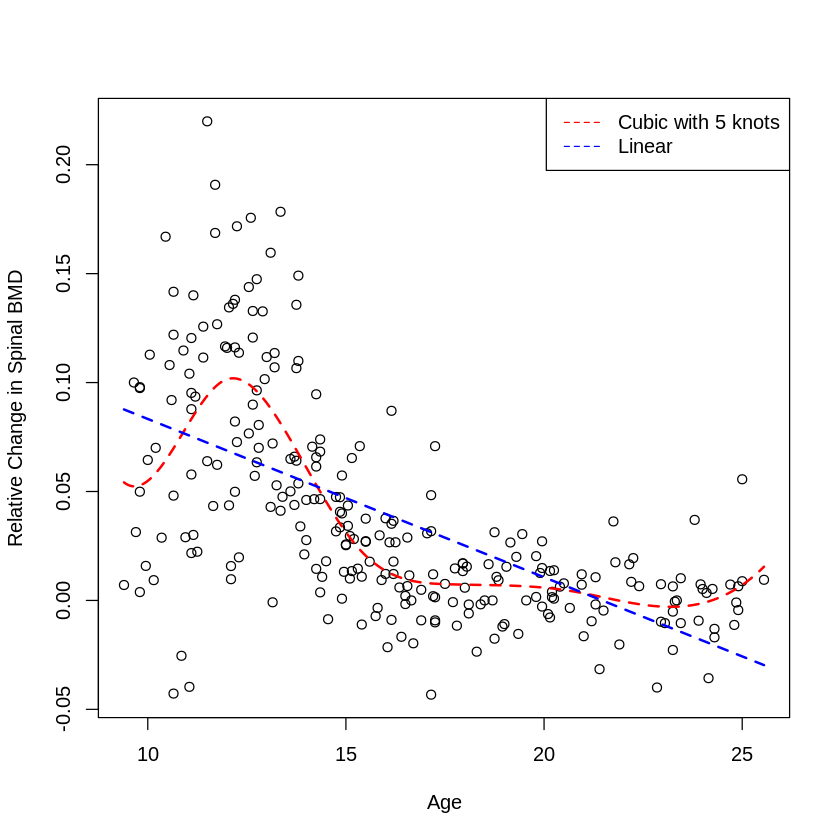

In [7]:
# Age values
age_vals <- seq(min(bmd_females_data$age), max(bmd_females_data$age), length.out = 500)

# Based on the plots above, optimal knot is 5
optimal_knots <- 5

# Fit the final cubic spline model with optimal knots
final_cubic_model <- suppressWarnings(lm(rspnbmd ~ bs(age,
                                                      df = optimal_knots + 3,
                                                      degree = 3),
                                         data = bmd_females_data))

final_cubic_model_train <- suppressWarnings(train(x = model.matrix(final_cubic_model)[,-1],
                                                  y = bmd_females_data$rspnbmd,
                                                  method = "lm",
                                                  trControl = train_control))


final_cubic_model_predict <- predict(final_cubic_model,
                                     newdata = data.frame(age = age_vals))

# Linear predictions
final_lm_model_predict <- predict(bmd_females_lm_10cv,
                                  newdata = data.frame(age = age_vals))

# Plot the final model
plot(bmd_females_data$age, bmd_females_data$rspnbmd,
     ylab = "Relative Change in Spinal BMD",
     xlab = "Age")
points(age_vals, final_cubic_model_predict, col = "red", type = "l", lty = 2, lwd = 2)
points(age_vals, final_lm_model_predict, col = "blue", type = "l", lty = 2, lwd = 2)
legend("topright", legend = c("Cubic with 5 knots", "Linear"), lty = 2, col = c("red", "blue"))

# Get CV RMSE and R-squared for the final model
final_cubic_model_train_10cv_rmse <- final_cubic_model_train$results$RMSE
final_cubic_model_train_10cv_r2 <- final_cubic_model_train$results$Rsquared


# Print results and create a plot
print(paste("Optimal number of knots:", optimal_knots))
print(paste("CV RMSE (Cubic Spline):", final_cubic_model_train_10cv_rmse))
print(paste("CV R-squared (Cubic Spline):", final_cubic_model_train_10cv_r2))

In [8]:
rmse_diff <- final_cubic_model_train_10cv_rmse - bmd_females_lm_10cv_rmse
r2_diff <- final_cubic_model_train_10cv_r2 - bmd_females_lm_10cv_r2

print(paste("The rmse diff between the cubic model and linear model is", rmse_diff))
print(paste("The r2 diff between the cubic model and the linear model is", r2_diff))

[1] "The rmse diff between the cubic model and linear model is -0.00585309272765501"
[1] "The r2 diff between the cubic model and the linear model is 0.146386376241218"


The cubic model has a lower rmse and a higher r2, which makes it better in both catagories. Visually, the red line, which represents the cubic model, looks to fit the more of the points compared to the blue linear line. This again is also evident of the higher r2.

# Question 2

(80 pts.) Data in the file sahd_data.csv was collected on a sample of 462 males in a heart-disease high-risk region of the Western Cape, South Africa. Information about the variables in the data set can be found here: https://hastie.su.domains/ElemStatLearn/datasets/SAheart.info.txt. You will use these data to construct and evaluate several models to predict coronary heart disease status (chd = 1 if yes, 0 if no) based on the other variables available in the data set. For each part below, if you use the train() function to perform cross-validation, set the seed to 1234 (set.seed(1234)) prior to running the function. Note that you should convert the famhist values from Present/Absent to 1/0 and you should convert the chd values from 0/1 to no/yes and convert it to a factor variable in R.

In [ ]:
# Load the sahd_data.csv data
sahd_data <- read_csv("/content/sahd_data.csv")

# Convert famhist to 0 and 1
sahd_data$famhist <- ifelse(sahd_data$famhist == "Present", 1, 0)

# Convert chd from 0/1 to 'no/yes' and make it a factor
sahd_data$chd <- factor(ifelse(sahd_data$chd == 1, "yes", "no"), levels = c("no", "yes"))

## (a)

(10 pts.) Fit a logistic model with coronary heart disease status as the response and the other variables
as potential predictors. Use a threshold of 0.5 and report the 10-fold CV accuracy for this model.

In [10]:
# Logistic Model with Thresholds
set.seed(1234)

# Define training control for 10-fold CV
lr_train_control <- trainControl(method = "cv",
                                 number = 10,
                                 classProbs = TRUE,
                                 summaryFunction = twoClassSummary,
                                 savePredictions = TRUE)

sahd_data_lr_10cv <- suppressWarnings(train(chd ~ .,
                                            data = sahd_data,
                                            method = "glm",
                                            family = "binomial",
                                            trControl = lr_train_control))

# use thresholder() function at 0.50 for predictions
sahd_data_lr_10cv_ths <- thresholder(sahd_data_lr_10cv,
                                     threshold = 0.50,
                                     final = FALSE,
                                     statistics = c("Sensitivity", "Specificity", "Accuracy", "Kappa"))

print(paste("The 10-fold CV accuracy for the logistic model using a 0.50 threshold is", sahd_data_lr_10cv_ths$Accuracy))

[1] "The 10-fold CV accuracy for the logistic model using a 0.50 threshold is 0.716466234967623"


## (b)

(20 pts.) Grow and prune a classification tree with coronary heart disease status as the response and the other variables as potential predictors. Use 10-fold CV accuracy with the one-SE rule to determine the optimal amount of pruning. Use the Gini index for splitting nodes and set the minimum number of
observations to split a node to 30 and the minimum number of observations in each terminal node to 10. Plot the classification tree and provide the 10-fold CV accuracy.

In [11]:
# Classification Tree
set.seed(1234)

sahd_data_ctree <- rpart(chd ~ .,
                         data = sahd_data,
                         method = "class",
                         parms = list(split = "gini"),
                         control = rpart.control(minsplit = 30,
                                                 minbucket = 10),
                         cp = 0)

# Get tuning grid for train function
tg_ctree <- data.frame(cp = sahd_data_ctree$cptable[,1])

# Define training control for 10-fold CV
ctree_train_control <- trainControl(method = "cv",
                                    number = 10,
                                    selectionFunction = "oneSE")

sahd_data_ctree_10cv <- suppressWarnings(train(chd ~ .,
                                               data = sahd_data,
                                               method = "rpart",
                                               parms = list(split = "gini"),
                                               control = rpart.control(minsplit = 30,
                                                                       minbucket = 10),
                                               tuneGrid = tg_ctree,
                                               trControl = ctree_train_control))

sahd_data_ctree_10cv

CART 

462 samples
  9 predictor
  2 classes: 'no', 'yes' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 415, 416, 416, 416, 415, 416, ... 
Resampling results across tuning parameters:

  cp       Accuracy   Kappa     
  0.01000  0.7121647  0.33830414
  0.01875  0.7187327  0.33055197
  0.02500  0.7209066  0.34479623
  0.06250  0.6906105  0.24277883
  0.10000  0.6884366  0.25220916
  0.12500  0.6558279  0.09286888

Accuracy was used to select the optimal model using  the one SE rule.
The final value used for the model was cp = 0.025.

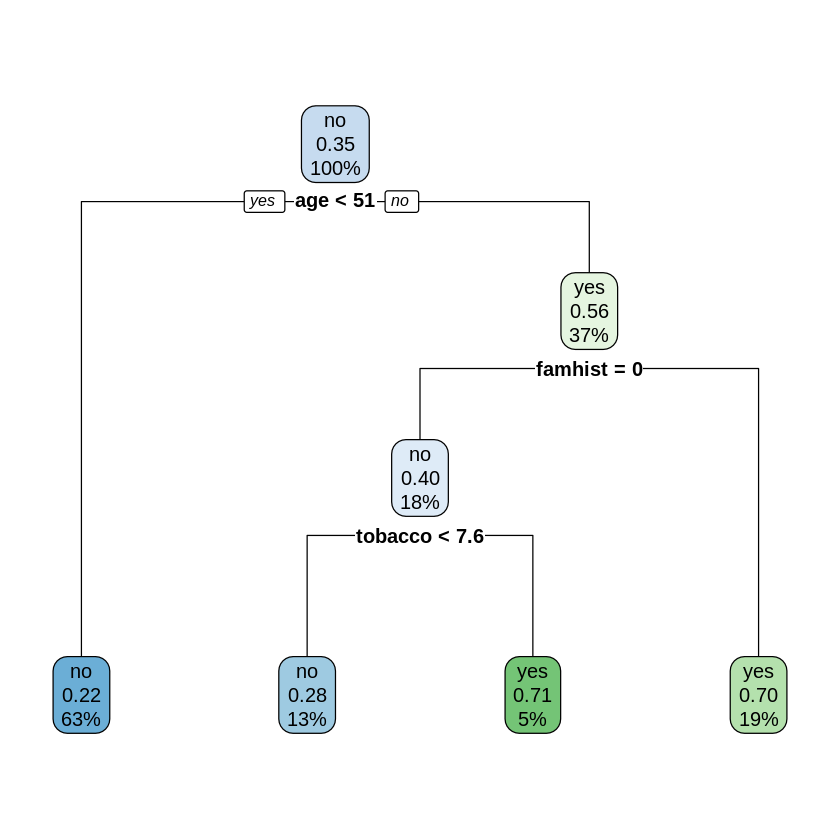

In [12]:
# Plot the final pruned classification tree
rpart.plot(sahd_data_ctree_10cv$finalModel)

The final value used for the model was cp = 0.02500, which had an accuracy of 0.7209066.

## (c)

(20 pts.) Fit a random forest classification model of 500 trees with coronary h response and the other variables as potential predictors. Use 10-fold CV accuracy to select the number of predictors to consider at each split in any given tree of the random forest. For your selected random forest, provide a relevant plot that provides evidence that 500 trees is enough for this random forest. (Hint, the finalModel object has an element err.rate with each row providing information on OOB error rate for the corresponding row’s number of trees from 1 to 500.) Report the OOB accuracy for the selected model. Present a variable importance plot based on mean decrease in Gini index. What are the top three predictors of coronary heart disease status based on the random forest model that you selected?

In [13]:
# Random Forest Classification Tree
set.seed(1234)

# Define training control for 10-fold CV
rftree_train_control <- trainControl(method = "cv",
                                     number = 10)

sahd_data_rfTree_10cv <- suppressWarnings(train(chd ~ .,
                                                data = sahd_data,
                                                method = "rf",
                                                ntree = 500,
                                                tuneGrid = data.frame(mtry = 1:ncol(sahd_data) - 1),
                                                trControl = rftree_train_control))

sahd_data_rfTree_10cv

Random Forest 

462 samples
  9 predictor
  2 classes: 'no', 'yes' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 416, 416, 415, 416, 415, 416, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
  0     0.7013414  0.2685533
  1     0.7014339  0.2687409
  2     0.6926457  0.2778811
  3     0.6906105  0.2710175
  4     0.6861702  0.2585081
  5     0.6839500  0.2579172
  6     0.6948659  0.2869702
  7     0.6818224  0.2590703
  8     0.6862165  0.2729599
  9     0.6796947  0.2509344

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 1.


Call:
 randomForest(x = x, y = y, ntree = 500, mtry = param$mtry) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 1

        OOB estimate of  error rate: 30.95%
Confusion matrix:
     no yes class.error
no  267  35    0.115894
yes 108  52    0.675000
[1] "Final Model OOB Accuracy: 0.69047619047619"


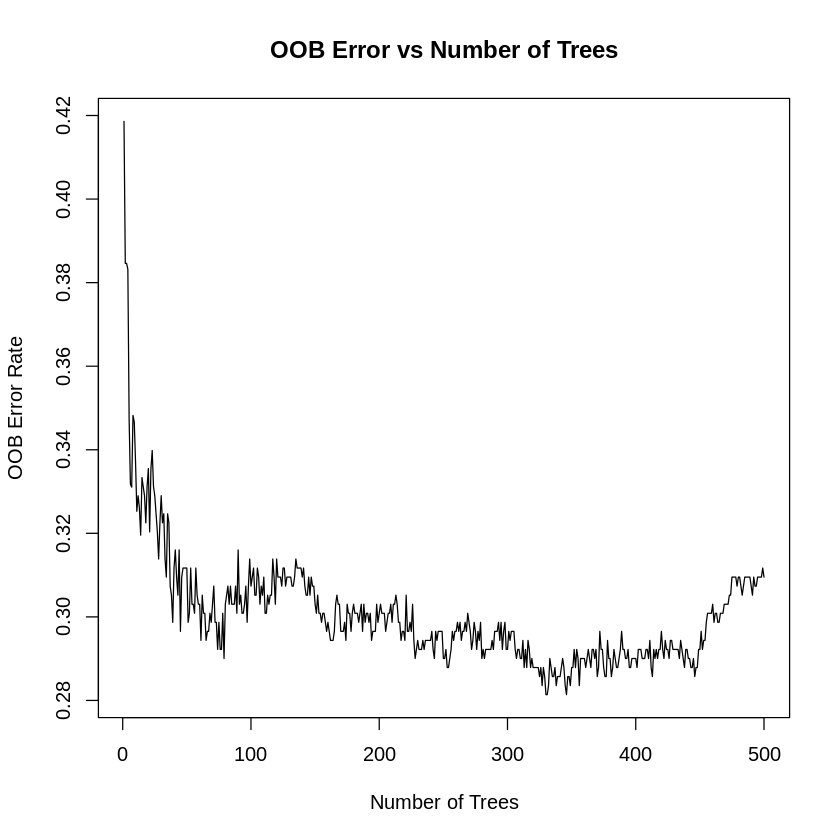

In [14]:
# Final Model
print(sahd_data_rfTree_10cv$finalModel)

# Final Model OOB accuracy
oob_accuracy <- 1 - sahd_data_rfTree_10cv$finalModel$err.rate[500, "OOB"]
print(paste("Final Model OOB Accuracy:", oob_accuracy))

# Plot Final Model OOB error rates over trees
plot(sahd_data_rfTree_10cv$finalModel$err.rate[, "OOB"],
     type = "l",
     main = "OOB Error vs Number of Trees",
     xlab = "Number of Trees",
     ylab = "OOB Error Rate")

Based on the OOB Error vs Number of Trees plot, it looks like the OOB Error rate stablizes after 100 trees, and further trees do not provide significant improvement in the OOB Error rate. This means that 500 tree is actually excessive and more than enough for this random forest.

[1] "The Top 3 Predictors are:"
[1] "age"     "tobacco" "ldl"    


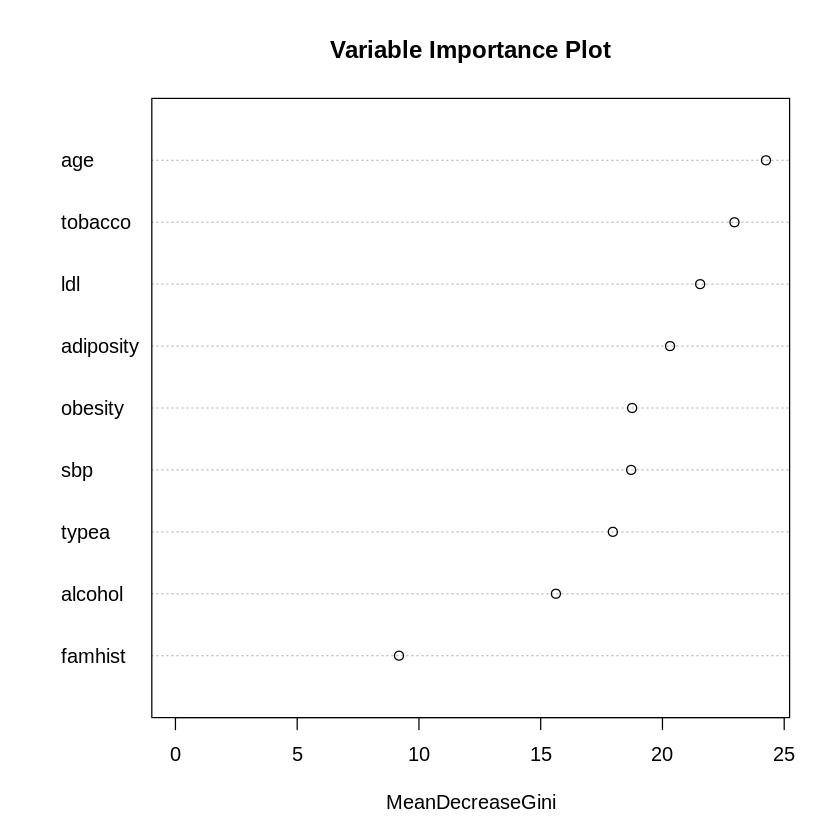

In [15]:
# Variable Importance Plot
varImpPlot(sahd_data_rfTree_10cv$finalModel, main = "Variable Importance Plot")

# Top 3 predictors
var_imp <- importance(sahd_data_rfTree_10cv$finalModel)
top3 <- head(sort(var_imp[, "MeanDecreaseGini"], decreasing = TRUE), 3)

print("The Top 3 Predictors are:")
print(names(top3))

## (d)

(25 pts.) Fit a boosted classification tree with coronary heart disease status as the response and the other variables as potential predictors. Use 10-fold CV accuracy to select the optimal combination of tuning parameters from the following: for the number of trees consider 5 to 50 in increments of 5;
for the number of splits for the trees consider 1 - 6; for the shrinkage parameter consider 0.20, 0.25, 0.30, 0.35, 0.40, and 0.45. Set the minimum number of observations in each terminal node to 10 and sample 50% of the training data before fitting each new tree. Report the optimal tuning parameter
combination and the corresponding 10-fold CV accuracy. Present a variable importance plot based on relative influence and construct partial dependence plots for the three most important predictors in the data set. Based on the partial dependence plots, what can be said about the relationship between each of the three predictor variables and coronary heart disease status?

In [ ]:
# Boosted Classification Tree
set.seed(1234)


# Set up tuning grid
tg_boostclass <- expand.grid(n.trees = seq(5, 50, by = 5),
                             interaction.depth = 1:6,
                             shrinkage = c(0.20, 0.25, 0.30, 0.35, 0.40, 0.45),
                             n.minobsinnode = 10)

# Define training control for 10-fold CV
boostclass_train_control <- trainControl(method = "cv",
                                         number = 10)

sahd_data_boostTree_10cv <- suppressWarnings(train(chd ~ .,
                                                   data = sahd_data,
                                                   method = "gbm",
                                                   bag.fraction = 0.5,
                                                   distribution = "bernoulli",
                                                   tuneGrid = tg_boostclass,
                                                   trControl = boostclass_train_control))

In [17]:
# Print optimal tuning parameters
print("Optimal Tuning Parameters are:")
sahd_data_boostTree_10cv$bestTune

[1] "Optimal Tuning Parameters are:"


,n.trees,interaction.depth,shrinkage,n.minobsinnode
,<dbl>,<int>,<dbl>,<dbl>
127,35,1,0.3,10


In [18]:
# Print Best Accuracy
OptimalTuningParameter_Index = 127

# Get Accuray of the 127th index as identified as best optimal tuning parameters
best_accuracy <- sahd_data_boostTree_10cv$results[rownames(sahd_data_boostTree_10cv$results) == 127, ]$Accuracy
print(paste("Best 10-fold CV Accuracy:", best_accuracy))

[1] "Best 10-fold CV Accuracy: 0.738112858464385"


,var,rel.inf
,<chr>,<dbl>
age,age,25.567394
tobacco,tobacco,19.532306
ldl,ldl,15.991037
typea,typea,9.666861
famhist,famhist,8.558206
adiposity,adiposity,7.116763
alcohol,alcohol,6.094453
obesity,obesity,4.130542
sbp,sbp,3.342438


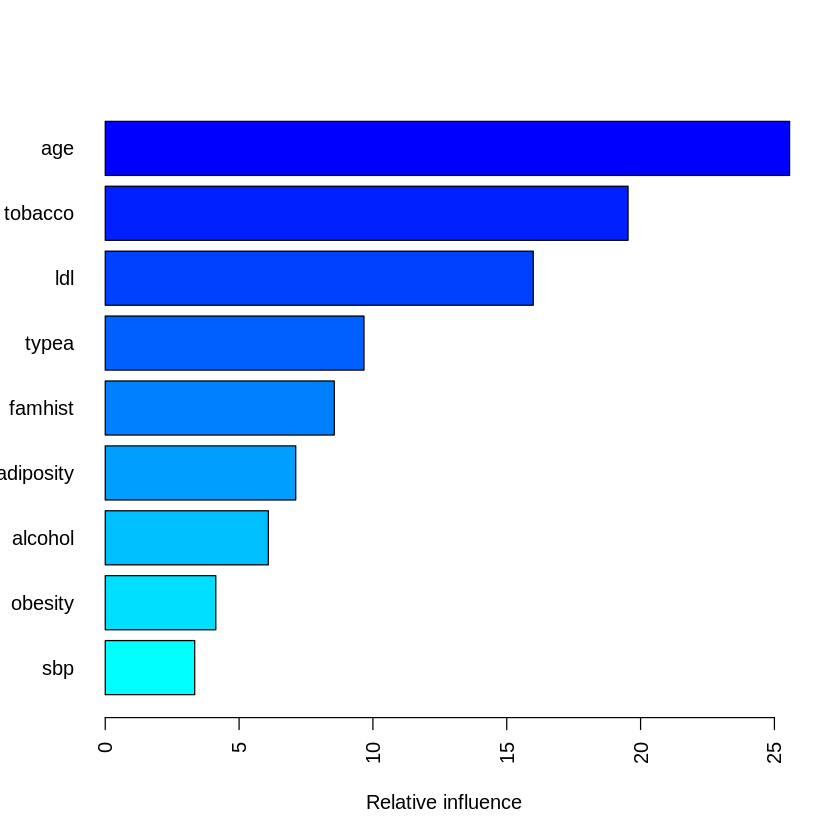

In [19]:
# Relative Influence approach Variable Importance
summary(sahd_data_boostTree_10cv$finalModel,
        method = relative.influence,
        normalize = TRUE, las = 2)

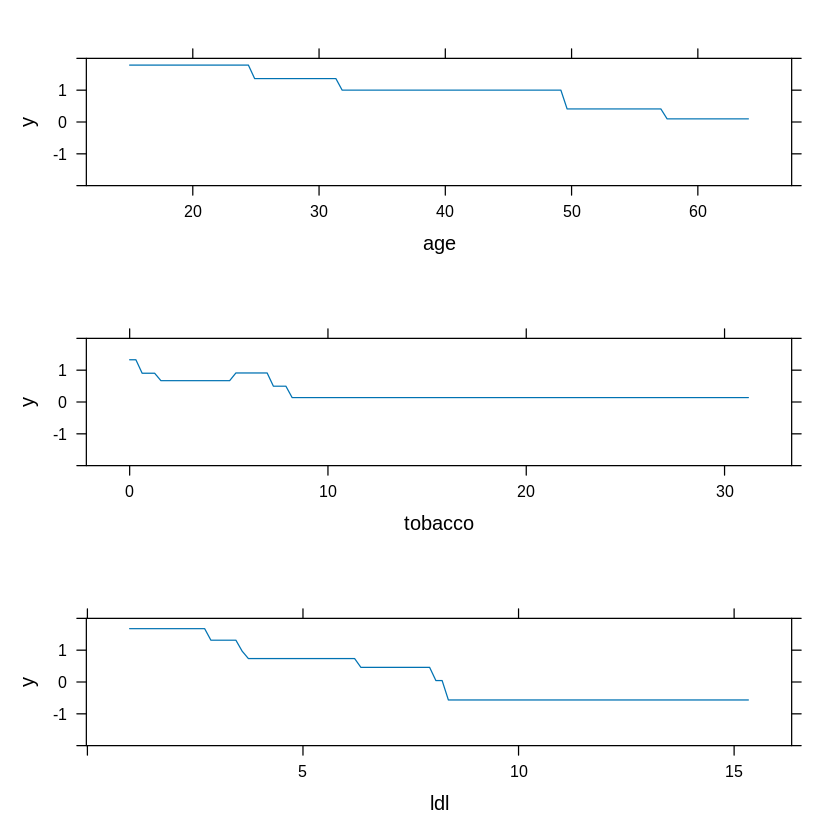

In [20]:
# Partial Dependence Plots
p1 <- plot(sahd_data_boostTree_10cv$finalModel, i = "age",
           ylim = c(-2, 2))

p2 <- plot(sahd_data_boostTree_10cv$finalModel, i = "tobacco",
           ylim = c(-2, 2))

p3 <- plot(sahd_data_boostTree_10cv$finalModel, i = "ldl",
           ylim = c(-2, 2))

grid.arrange(p1, p2, p3, ncol = 1, nrow = 3)

The vertical axis is log odds of predicting cdh = "No".

For the `age` partial dependence plot, it looks like at a young age, you have a higher chance to have "No" predicted coronary heart disease status, which decreases as your age increases.

For the `tobacco` partial dependence plot, it looks like less cumulative tobaccos use has a higher chance to have "No" predicted coronary heart disease status, which then doesn't have any differential impact after a little less than 10 kg of cumulative tobacco use.

For the `ldl` partial dependence plot, it looks like having a low ldl will predict "No" for coronary heart disease status, but flips overtime to predicting "Yes" at higher ldl values.

## (e)

(5 points) Of the models considered in parts (a) - (d), which is the best with respect to prediction accuracy? Justify your response.

In [21]:
# Note variable names are what I happen to use to hold accuracy values, thus not as consistent as I would like.
print("Accuracy Values:")
print(paste("(a) -- Logistic model using a 0.50 threshold is", sahd_data_lr_10cv_ths$Accuracy))
print(paste("(b) -- Classification Tree is 0.7209066"))
print(paste("(c) -- Random Forest Classification Tree is", oob_accuracy))
print(paste("(d) -- Boosted Classification Tree is", best_accuracy))

[1] "Accuracy Values:"
[1] "(a) -- Logistic model using a 0.50 threshold is 0.716466234967623"
[1] "(b) -- Classification Tree is 0.7209066"
[1] "(c) -- Random Forest Classification Tree is 0.69047619047619"
[1] "(d) -- Boosted Classification Tree is 0.738112858464385"


Based on just the prediction accuracy, it looks like the **Boosted Classification Tree** is the best model for this sahd dataset with the highest accuracy of 0.74.